# Group assignment 2: FacetForge

**Team members** :Yasaman Asgari, Thomas Brighton, Muhmmad Ansar, Mohammad Mahdi Hejazi

**Link to github**: https://github.com/YasAsgari/IVDA 


**Contribution**: Yasaman Asgari did the pre-processing on the attributes and the dimensionality reduction and applied the entropy for the clustering. 
Brighton Thomas did the clustering and exporting. 
Muhammad Ansar and Mohammadmahdi Hejazi did the sketch and the proptotype.


**Goal of visualisation** "FacetForge" is an interactive sustainable visualization application that digitizes historical documents' attributes(at this stage) through visual searches and exploration of information landscapes. 

**Tasks list**:
1. Filter: Narrow down the dataset by applying conditions on attributes (e.g., filtering documents written in
”Deutsch”).
2. Identify: Locate and access a specific document or set of documents of interest.
3. Discover: the relationship between the dimensionality reduction and the attributes.
4. 






In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import re
import plotly.express as px
import ast
from geopy.geocoders import Nominatim
from tqdm import tqdm
tqdm.pandas()
import seaborn as sns
import plotly.graph_objects as go


In [2]:
df=pd.read_csv('items.csv')

In [3]:
df.columns

Index(['series', 'identifier_swisscollections', 'subject_form',
       'library_call_number', 'resource_type',
       'date_of_publication_or_production_standardised', 'place_standardised',
       'physical_description', 'language', 'title'],
      dtype='object')

## Preprocessing of the date standardised: 

  - `date_of_publication_or_production_standardised` is a string column containing various date formats, such as `YYYYMMDD`, `YYYY`, or ranges like `YYYY-YYYY`.  
  - `found_date` is an integer column derived from parsing the original dates, representing the year of publication or production.
  - The distribution of `found_date` was visualized using a histogram with 1000 bins to provide a high-resolution view of publication frequencies over time. The resulting chart highlights periods of high and low activity, revealing trends and anomalies in the data.

  - Missing or unparsable values in `date_of_publication_or_production_standardised` result in `None` in `found_date`. These missing values can be quantified using `df['found_date'].isnull().sum()` and appropriately managed.
  - Extreme dates, such as years far in the past (e.g., pre-1500) or future, may indicate errors in parsing or input data. These can be identified by filtering for years within a reasonable range (e.g., 1500–2024).
  - The dataset contains inconsistent date formats (e.g., `YYYYMMDD`, `YYYY`, and ranges like `1930-1972`). The extraction logic is designed to standardize these formats, though irregularities may still arise from unconventional formats.
  - Validity checks ensure that `found_date` values fall within a plausible range for publication years. Invalid or erroneous dates are replaced with `None`.

Goal: The primary goal is to visualize and analyze publication trends over time to identify patterns, peak periods, and gaps. This requires standardizing and cleaning the date data to ensure accurate and meaningful visualizations.

In [4]:
def find_date_of_publication(x):
    try:
        # Split the input by `/` or `-` to prioritize the first date segment
        segments = re.split(r'[/-]', x)
        for segment in segments:
            # Process each segment as a potential date
            segment = segment.strip()
            if len(segment) == 8:  # YYYYMMDD format
                try:
                    return pd.to_datetime(segment, format='%Y%m%d', errors='coerce').year
                except ValueError:
                    continue
            elif len(segment) == 4:  # Year
                return int(segment)

        # Check for year ranges like '1930-1972' and take the start year
        match_range = re.search(r'\b(\d{4})-(\d{4})\b', x)
        if match_range:
            return int(match_range.group(1))  # Return the first year in the range

        # If no valid date is found, fallback to extracting a 4-digit year
        match_year = re.search(r'\b(\d{4})\b', x)
        if match_year:
            return int(match_year.group(1))
         # Original logic for numeric-like processing
        
        result = ''.join(char for char in x if char.isdigit() or char in ['/', ',', '-'])
        if result[0] == '-':
            result = result[1:]

        if '/' in result:
            result = result.split('/')[0]
        if ',' in result:
            result = result.split(',')[0]
        if '-' in result:
            result = result.split('-')[0]

        if len(result) == 4:  # Year
            return int(result)
        if len(result) == 8:  # YYYYMMDD or DDMMYYYY
            try:
                return pd.to_datetime(result, format='%Y%m%d').year
            except ValueError:
                try:
                    return pd.to_datetime(result, format='%d%m%Y').year
                except ValueError:
                    return None
        else:
            return int(result[:4])  # Fallback to the first 4 digits if all else fails

    except Exception as e:
        print(f"Error processing: {x}, Exception: {e}")
        return None


In [5]:
df['found_date']=df.date_of_publication_or_production_standardised.apply(find_date_of_publication)

In [6]:
fig = px.histogram(
    df,
    x='found_date',
    nbins=1000,  # Adjust the number of bins
    title='Distribution of Found Dates',
    color_discrete_sequence=['indianred']  # Change the bar color
)
fig.update_layout(
    xaxis_title='Found Date',
    yaxis_title='Count'
)
fig.show()


In [7]:
df['found_date'].isnull().sum() #34 values with None are found. 

34

In [8]:
df[df['found_date']>2024].shape #No values in future.

(0, 11)

In [9]:
df[df['found_date']<1500].shape #3 documents below that are possibly wrong so we will remove them.

(3, 11)

In [10]:
df=df[(df['found_date']>=1500) | (~ df['found_date'].isnull())]

## Preprocessing of the language: 
  -  `language` is String (Categorical, as the content represents various languages).
  - Initially, the values in this feature had inconsistencies such as different spellings, formats, and brackets. After applying transformations, the values have been normalized (e.g., "French" becomes "Französisch").
  -  The feature contains distinct languages like "Deutsch," "Französisch," "Englisch," and "Türkisch," among others. Post-cleaning.
  - Entries are mapped to a predefined dictionary (`mapping_language`) to ensure all values are valid and belong to a known set of languages.

The primary goal is to analyze and visualize the multilingual nature of the dataset, understanding the distribution and prevalence of languages across records. Key objectives include identifying the dominant languages, patterns of multilingual records, and potential correlations between languages and other dataset attributes. To achieve this, the data requires extensive preprocessing to ensure consistency and accuracy. This includes cleaning the `language` feature, standardizing names using a mapping, and handling compound entries (e.g., separating "Deutsch und Französisch"). Missing and invalid values must be flagged and addressed, while outliers are reviewed to maintain reliability. The corrected data (`corrected_lang`) will serve as a foundation for creating meaningful visualizations, such as bar charts and network diagrams, and for applying clustering models to group records based on language similarities.

In [11]:
df['language'] = df['language'].str.replace("[\[\]']", '', regex=True)  # Remove brackets and quotes
df['language'] = df['language'].str.split(',\s*')  # Split by commas with optional whitespace

mapping_language={'In Kurzenberger-Mundart':'Deutsch','In Alter Häädler-Sprooch':'Deutsch','Vinzel':'Deutsch','Schweizerdeutsch (Alte Häädler Puuresproch)':'Deutsch','Ranzösisch':'Französisch','Osmanisch-Türkisch':'Türkisch','Notizen Vorwiegend Deutsch':'Deutsch','Notizen Deutsch':'Deutsch','Niederdeutsch':'Deutsch','Deutsch Oder Schweizerdeutsch':'Deutsch',
                  
                  'Schweizerdeutsch':'Deutsch', 'Baseldeutsch':'Deutsch','English':'Englisch','England':'Englisch','Deusch':'Deutsch','Detusch':'Deutsch'  ,  "Franzsösisch": "Französisch",
    "Französich": "Französisch",
    "Franösisch": "Französisch",'French':'Französisch','German':'Deutsch','Lateinisch':'Latein','Titel: Deutsch':'Deutsch','Turkisch':'Türkisch','Urdu ?':'Urdu','deutsch':'Deutsch','französisch':'Französisch','Paris':'Französisch','Ger':'Deutsch','Russian':'Russisch','Handgeschriebenes Gedicht Schweizerdeutsch':'Deutsch','Einleitung Deutsch':'Deutsch','Haupttext Deutsch ; Unterschrift Aleksanderʺ In Alter Russischer Schrift':'Deutsch','Dialoge Schweizerdeutsch':'Deutsch','Deutschsprachiger Entwurf':'Deutsch','Italienische':'Italienisch','Nebst Latein':'Latein'}


# Function to split on "und" and replace with a list of words
def split_on_und(values):
    new_values=[]
    for value in values:
        
        value = ''.join([i for i in value if not i.isdigit()])
        
        
    # Remove extra spaces
        value = ' '.join(value.split())
        if 'Texte' in value:
            value=value.replace('Texte','')
            value=value.strip()
        if 'Text' in value:
            value=value.replace('Text','')
            value=value.strip()
        if ' und ' in value:
            new_list=value.split(' und ')
            for v in new_list:
                v=v.title().strip()
                if v in mapping_language:
                 
                    new_values.append(mapping_language[v.strip()].title())
                else:
       
                    new_values.append(v.title())
        else:
            if value.title() in mapping_language:
                
                new_values+=[mapping_language[value.title().strip()]]
            else:
                new_values+=[value.title()]
    return list(set(new_values))


df['Languages_Clean']=df.language.apply(split_on_und)


In [12]:
# Explode the languages into multiple rows for histogram
df_exploded = df.explode('Languages_Clean')

df_exploded=df_exploded.value_counts('Languages_Clean').reset_index()


# Create a bar chart of languages
fig = px.bar(
    df_exploded,
    x='Languages_Clean',
    y='count',  # Replace 0 with the column name if the counts column is named differently
    title='Language Distribution',
    labels={'Languages_Clean': 'Languages', 0: 'Count'},
    text_auto=True
)
fig.show()


In [13]:
df_exploded['count']/=df_exploded['count'].sum()
df_exploded

,Languages_Clean,count
0,Deutsch,0.842495
1,Französisch,0.093952
2,Englisch,0.041185
3,Italienisch,0.008957
4,Latein,0.003559
5,Russisch,0.003274
6,Spanisch,0.001121
7,Türkisch,0.001121
8,Arabisch,0.000816
9,Griechisch,0.000590


Since most of the data is in german and there is a gap between the distribution of the values, we will keep the languages as if they have a share more than the 0.2 % of document. If not they are mapped to ""Other"".

In [14]:
# Filter languages once and store them in a set for faster lookup
languages_to_filter = set(df_exploded.loc[df_exploded['count'] < 0.002, 'Languages_Clean'])

# Define the mapping function
def map_lang(list_lang):
    # Use a list comprehension for more concise and efficient mapping
    return list(set('Other' if lang in languages_to_filter else lang for lang in list_lang))

# Apply the function to the dataframe
df['Languages_Clean_other_mapped'] = df['Languages_Clean'].apply(map_lang)


In [15]:
# Explode the languages into multiple rows for histogram
df_exploded = df.explode('Languages_Clean_other_mapped')

df_exploded=df_exploded.value_counts('Languages_Clean_other_mapped').reset_index()


# Create a bar chart of languages
fig = px.bar(
    df_exploded,
    x='Languages_Clean_other_mapped',
    y='count',  # Replace 0 with the column name if the counts column is named differently
    title='Language Distribution',
    labels={'Languages_Clean': 'Languages', 0: 'Count'},
    text_auto=True
)
fig.show()


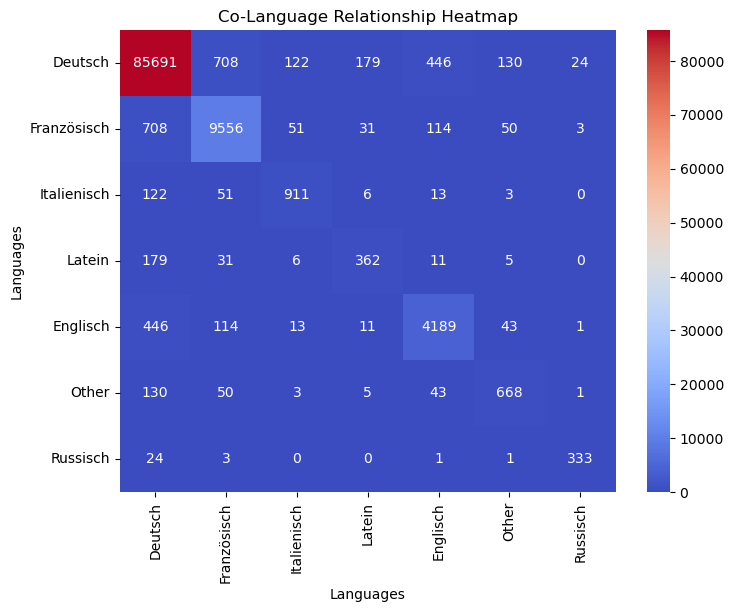

In [16]:

# Explode the Languages column into individual rows and get co-occurrences
all_languages = pd.Series([lang for sublist in df["Languages_Clean_other_mapped"] for lang in sublist]).unique()
cooccurrence_matrix = pd.DataFrame(0, index=all_languages, columns=all_languages)

for langs in df["Languages_Clean_other_mapped"]:
    for i, lang1 in enumerate(langs):
        for lang2 in langs[i:]:
            cooccurrence_matrix.at[lang1, lang2] += 1
            if lang1 != lang2:
                cooccurrence_matrix.at[lang2, lang1] += 1

# Plot a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cooccurrence_matrix, annot=True, cmap="coolwarm", fmt="d")
plt.title("Co-Language Relationship Heatmap")
plt.xlabel("Languages")
plt.ylabel("Languages")
plt.show()


So we will do the one-hot encoding since it is importnat to preserve the relationship of the languages.

## Preprocessing of subject form

In [17]:
df['corrected_subject_form'] = df['subject_form'].str.replace("[\[\]']", '', regex=True)  # Remove brackets and quotes
df['corrected_subject_form'] = df['corrected_subject_form'].str.split(',\s*')  # Split by commas with optional whitespace

# Step 2: Flatten the list of lists and find unique values
unique_subjects = set([subj.strip() for sublist in df.corrected_subject_form for subj in sublist])

# Display the result as a sorted list
unique_subjects = sorted(unique_subjects)
len(unique_subjects)

49

In [18]:
# Explode the languages into multiple rows for histogram
df_exploded = df.explode('corrected_subject_form')

df_exploded=df_exploded.value_counts('corrected_subject_form').reset_index()


# Create a bar chart of languages
fig = px.bar(
    df_exploded,
    x='corrected_subject_form',
    y='count',  # Replace 0 with the column name if the counts column is named differently
    title='Subject form Distribution',
    
    text_auto=True
)
fig.show()


In [19]:
df_exploded['count']/=df_exploded['count'].sum()
df_exploded

,corrected_subject_form,count
0,Briefsammlung,0.379307
1,Handschrift,0.357861
2,Autograf,0.244599
3,Rede,0.007158
4,Fotografie,0.002275
5,Musikhandschrift,0.001936
6,Tagebuch,0.000975
7,Predigt,0.000747
8,Partitur,0.000655
9,Katalog,0.000636


In [20]:


# Filter subject once and store them in a set for faster lookup
subject_to_filter = set(df_exploded.loc[df_exploded['count'] < round(0.000975, 4), 'corrected_subject_form'])

# Define the mapping function
def map_subject(list_subject):
    # Use a list comprehension for more concise and efficient mapping
    return list(set('Other' if subj in subject_to_filter else subj for subj in list_subject))

# Apply the function to the dataframe
df['subject_Clean_other_mapped'] = df['corrected_subject_form'].apply(map_subject)


In [21]:
# Explode the languages into multiple rows for histogram
df_exploded = df.explode('subject_Clean_other_mapped')

df_exploded=df_exploded.value_counts('subject_Clean_other_mapped').reset_index()


# Create a bar chart of languages
fig = px.bar(
    df_exploded,
    x='subject_Clean_other_mapped',
    y='count',  # Replace 0 with the column name if the counts column is named differently
    title='Subject form Distribution',
    
    text_auto=True
)
fig.show()


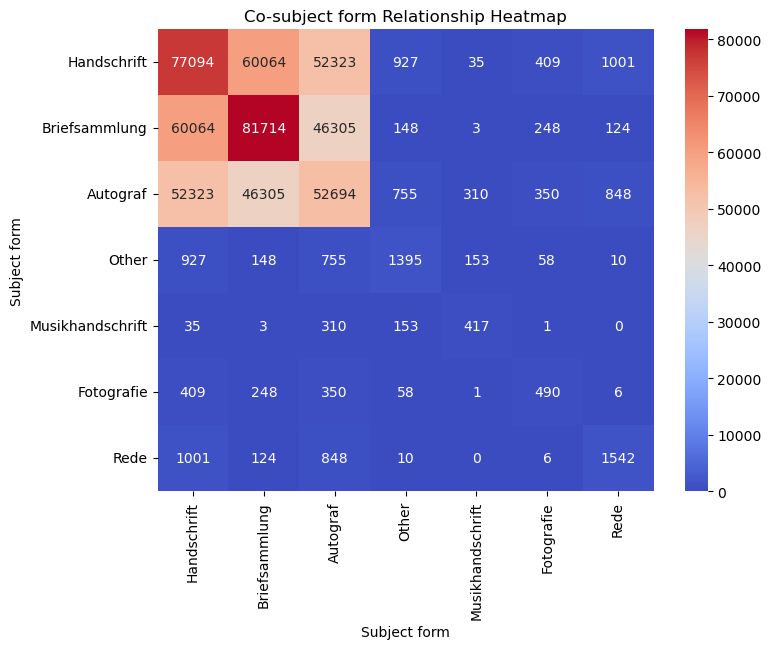

In [22]:

# Explode the Languages column into individual rows and get co-occurrences
all_languages = pd.Series([lang for sublist in df["subject_Clean_other_mapped"] for lang in sublist]).unique()
cooccurrence_matrix = pd.DataFrame(0, index=all_languages, columns=all_languages)

for langs in df["subject_Clean_other_mapped"]:
    for i, lang1 in enumerate(langs):
        for lang2 in langs[i:]:
            cooccurrence_matrix.at[lang1, lang2] += 1
            if lang1 != lang2:
                cooccurrence_matrix.at[lang2, lang1] += 1

# Plot a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cooccurrence_matrix, annot=True, cmap="coolwarm", fmt="d")
plt.title("Co-subject form Relationship Heatmap")
plt.xlabel("Subject form")
plt.ylabel("Subject form")
plt.show()


So we will do the one-hot encoding since it is importnat to preserve the relationship of the subject form.

In [23]:

df['corrected_resource_type'] = df['resource_type'].str.replace("[\[\]']", '', regex=True)  # Remove brackets and quotes
df['corrected_resource_type'] = df['corrected_resource_type'].str.split(',\s*')  # Split by commas with optional whitespace

In [24]:

# Step 2: Flatten the list of lists and find unique values
unique_resource_type= set([subj.strip() for sublist in df.corrected_resource_type for subj in sublist])
# Display the result as a sorted list
unique_resource_type = sorted(unique_resource_type)
len(unique_resource_type)

14

In [25]:
# Explode the languages into multiple rows for histogram
df_exploded = df.explode('corrected_resource_type')

df_exploded=df_exploded.value_counts('corrected_resource_type').reset_index()


# Create a bar chart of languages
fig = px.bar(
    df_exploded,
    x='corrected_resource_type',
    y='count',  # Replace 0 with the column name if the counts column is named differently
    title='Resource type form Distribution',
    
    text_auto=True
)
fig.show()


In [26]:
df_exploded['count']/=df_exploded['count'].sum()
df_exploded

,corrected_resource_type,count
0,Brief,0.349749
1,Archivmaterial / Archivdokument,0.249264
2,Autograph,0.225145
3,Archivmaterial / Dossier,0.099336
4,Buchhandschrift,0.068508
5,Handschrift,0.004119
6,Musikhandschrift,0.001773
7,Archivmaterial / Serie,0.000743
8,Partitur,0.000602
9,Archivmaterial / Bestand,0.000500


In [27]:


# Filter resource once and store them in a set for faster lookup
resource_to_filter = set(df_exploded.loc[df_exploded['count'] < round(0.000743, 4), 'corrected_resource_type'])

# Define the mapping function
def map_resource(list_resources):
    # Use a list comprehension for more concise and efficient mapping
    return list(set('Other' if subj in resource_to_filter else subj for subj in list_resources))

# Apply the function to the dataframe
df['resource_Clean_other_mapped'] = df['corrected_resource_type'].apply(map_resource)


In [28]:
# Explode the languages into multiple rows for histogram
df_exploded = df.explode('resource_Clean_other_mapped')

df_exploded=df_exploded.value_counts('resource_Clean_other_mapped').reset_index()


# Create a bar chart of languages
fig = px.bar(
    df_exploded,
    x='resource_Clean_other_mapped',
    y='count',  # Replace 0 with the column name if the counts column is named differently
    title='Resource type form Distribution',
    
    text_auto=True
)
fig.show()


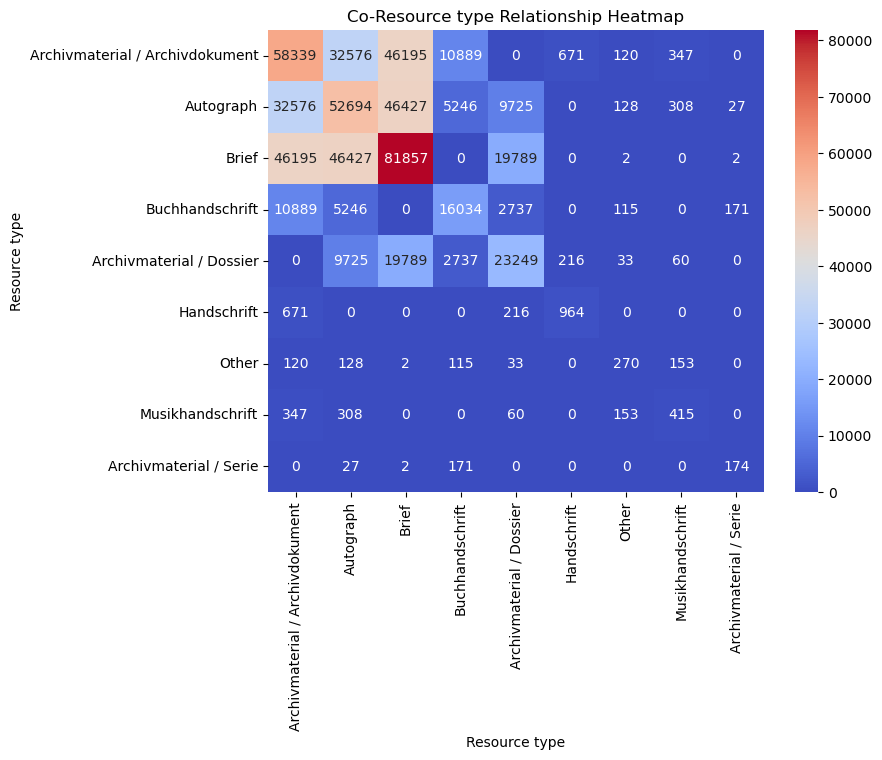

In [29]:

# Explode the Languages column into individual rows and get co-occurrences
all_languages = pd.Series([lang for sublist in df["resource_Clean_other_mapped"] for lang in sublist]).unique()
cooccurrence_matrix = pd.DataFrame(0, index=all_languages, columns=all_languages)

for langs in df["resource_Clean_other_mapped"]:
    for i, lang1 in enumerate(langs):
        for lang2 in langs[i:]:
            cooccurrence_matrix.at[lang1, lang2] += 1
            if lang1 != lang2:
                cooccurrence_matrix.at[lang2, lang1] += 1

# Plot a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cooccurrence_matrix, annot=True, cmap="coolwarm", fmt="d")
plt.title("Co-Resource type Relationship Heatmap")
plt.xlabel("Resource type")
plt.ylabel("Resource type")
plt.show()


So we will do once more the one hot encoding.

# Preprocessing the place standardised

In [30]:
# Convert the 'city_info' column from string to dictionary
df['place_standardised'] = df['place_standardised'].apply(ast.literal_eval)

# Optionally, extract the 'name' and 'identifier' fields into separate columns
df['city_info'] = df['place_standardised'].apply(lambda x: x['name'])

In [31]:
df_cities=pd.read_csv('worldcities.csv')
df=df.merge(df_cities[['city','lat','lng','country']], right_on='city',left_on='city_info', how='left')

In [ ]:
# Define function to get latitude and longitude
def get_lat_long(city_name):
    try:
        geolocator = Nominatim(user_agent='myapplication')
        location = geolocator.geocode(city_name)
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except: 
        print(city_name)
        return None, None
cities=df[df.city.isna()]['city_info'].unique()
city_mapping={city:get_lat_long(city) for city in tqdm(cities)}

  7%|▋         | 277/4194 [02:57<2:00:23,  1.84s/it]

Deufstetten


  7%|▋         | 294/4194 [03:07<36:52,  1.76it/s]  

In [ ]:
# Transforming data into a DataFrame

# Apply function to the DataFrame column
#df[['place_latitude', 'place_longitude']] = df['city_info'].progress_apply(lambda x: pd.Series(get_lat_long(x)))

#df_city_geocoded = pd.DataFrame.from_dict(city_mapping, orient='index', columns=['Latitude', 'Longitude'])
#df_city_geocoded.reset_index(inplace=True)
#df_city_geocoded.rename(columns={'index': 'City'}, inplace=True)
#df_city_geocoded.to_csv('df_city_geocoded.csv')
#city_mapping=df_city_geocoded.to_dict(orient='index')

In [ ]:
df_city_geocoded=pd.read_csv('df_city_geocoded.csv')
del df_city_geocoded['Unnamed: 0']
df_city_geocoded.set_index('City', inplace=True)




In [ ]:
for i, row in df[df.lat.isna()].iterrows():
    if pd.isna( row['lat']):
        df.at[i, 'lat']=city_mapping[df.at[0, 'city_info']]['Latitude']
    if pd.isna( row['lng']):
        df.at[i, 'lng']=city_mapping[df.at[0, 'city_info']]['Longitude']

In [ ]:
df=df[~df.lng.isna()]

In [ ]:
df.to_csv('final_df.csv', index=False)

In [ ]:
city_df_plot=df.groupby(['city_info','lat', 'lng'])['series'].count().reset_index().rename(columns={'city_info':'city', 'series':'count'})
city_df_plot=city_df_plot.sort_values('lng', ascending=False).drop_duplicates(['city'],keep='first')
# Create the map plot with circles sized by 'count'
fig = px.scatter_mapbox(
    city_df_plot, 
    lat="lat", 
    lon="lng", 
    size_max=50, 
    hover_name="city",
    size='count',
    hover_data={"count": True},
    title="Records distribution by Piece's location",
    mapbox_style="open-street-map",
    zoom=1,
    center={"lat": 49, "lon": 10}
)



fig.show()
